In [52]:
%pylab inline
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
import matplotlib
import pandas as pd
from scipy import interpolate
from sympy import *
import os
import io

Populating the interactive namespace from numpy and matplotlib


/share/soft/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['trace', 'gcd', 'Number', 'add', 'cbrt', 'ifft', 'interactive', 'partition', 'fft', 'plotting', 'sin', 'test', 'vectorize', 'mod', 'array', 'sinh', 'gamma', 'reshape', 'deprecated', 'binomial', 'sqrt', 'tanh', 'power', 'sinc', 'product', 'source', 'erf', 'det', 'prod', 'ones', 'diff', 'log', 'solve', 'cos', 'diag', 'trunc', 'eye', 'seterr', 'floor', 'Polygon', 'flatten', 'take', 'Line2D', 'beta', 'zeros', 'roots', 'nan', 'multinomial', 'transpose', 'cosh', 'lcm', 'tan', 'exp', 're', 'Circle', 'var', 'sign', 'poly', 'conjugate', 'plot', 'invert', 'pi']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# some basic unchanged parameters

In [115]:
d=200.        # diameter of the telescope, in cm unit

#if(keyword_set(teld)) then d=teld

obscure=0.0  #effective central obscuration, no unit
telarea=3.14159/4.0*d*d*(1.0-obscure)  #effective area of the telescope, cm^2
darkc=0.017   #dark current, in e/s/pix

#if(keyword_set(darkcurrent)) then darkc=darkcurrent

rn=4     #read noise, in e/pix

#if(keyword_set(readnoise)) then rn=readnoise

planckh=6.626    # 10^{-27} erg*s
cc=3.0   # speed of light, 10^{17} nm/s


# load the filters

In [171]:
filtersel='bessell_V.par'   #'./sdss_g0.par'
#if(keyword_set(filter)) then filtersel=filter
filterpath='../obs/filters/'
filterfile=filterpath+filtersel
print(filterfile)
# ;fluxfilter: max=1, min=0, no particular unit
i=0
with open(filterfile,'r') as fh:
    for line in fh:
        if line.startswith('#'):
            i=i+1
            continue
band=pd.read_csv(filterfile,sep='\s+',header=None,skiprows=40)
wavefilter=np.array(band[0])
fluxfilter=np.array(band[1])
wavefilter=wavefilter/10.0  # in nm
vmin=wavefilter[0]
nw=len(wavefilter)
vmax=wavefilter[nw-1]

# find the central wavelength, effective wavelength, and FWHM of the given filter

filtermid=(vmax-vmin)*0.5  #nm, central wavelength
dwave=wavefilter[1:]-wavefilter[:-1]
filtereff=np.nansum(dwave*wavefilter[1:]*fluxfilter[1:])/np.nansum(dwave*fluxfilter[1:]) #nm, effective wavelength
rmax=np.max(fluxfilter)
nnn=np.where(fluxfilter > 0.5*rmax)[0]
FWHMmin=wavefilter[nnn[0]]
FWHMmax=wavefilter[nnn[-1]]
filterwid=FWHMmax-FWHMmin  #nm, FWHM

../obs/filters/bessell_V.par


# define wavelength array,
- cover the range of 350nm to 1050nm, depend on the spectral resolution wanted. 

In [172]:
#specr0=2000  ; no unit
#if(keyword_set(specr)) then specr0=specr
sampling=2.0    #pixels per spectral resolution element ?1D or 2D/linear or area?

#if(keyword_set(specsample)) then sampling=specsample

#delta_lambda=500.0/specr0/sampling  ; in the same unit as lambda0
delta_lambda=0.1755555
#if(keyword_set(deltal)) then delta_lambda=deltal # has to be in unit of nm
narray=int((1000.0-350.0)/delta_lambda)  
#figure out the wavelength array length, from 350nm to 1000nm, spacing at delta_lambda
wavearr=350.0+delta_lambda*pl.frange(narray-1)
# select out the array of V band filter
ii=np.logical_and(wavearr >= vmin, wavearr <= vmax)
wavetmp2=wavearr[ii]
x=np.interp(wavetmp2,wavefilter,fluxfilter)
integratef4=x*wavetmp2

/share/soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: numpy.arange
  if sys.path[0] == '':


In [173]:
def integral(x,y):
    nn=len(x)
    
    dx=x[1:]-x[:-1]
    yy=0.5*(y[1:]+y[:-1])
  
    return np.sum(dx*yy)
    

In [174]:
integconst=integral(wavetmp2, integratef4) # int(lambda*Rlambda*dlambda)

In [175]:
integconst

44654.97566743437

# some less basic parameters, may change, but not often
- qsys=0.10	; throughput of the whole system, should be a function of lambda

In [176]:
throughput=pd.read_csv('../obs/IFU_throughput.dat',sep='\s+',header=None,skiprows=1)
lambdaq=np.array(throughput[8])
qtot=np.array(throughput[9]) #; throughput of the whole system,
#if(not keyword_set(qinput)) then qinput=1.0
qinput=1.0
qe=0.8 
#;assuming the total throughput cannot reach the theory value, 0.3 is the upper limit. 
qtot[qtot>=0.3]=0.3 
q=qtot*qinput #*qe ;qtot of CSST already includes the CCD efficiency 
fovsp=0.2  # diameter of fiber (or spaxel) in arcsec ?
#fov2=3.14159/4.0*(0.2)^2      ; fiber area in (arcsec)^2
fov2=(fovsp)**2     #*3.14159/4.0      ; fiber (or spaxel) area in (arcsec)^2
#if(keyword_set(fovp)) then fov2=(fovp)^2;*3.14159/4.0
#   for slit (point source)
#if(keyword_set(slitwidth)) then fov2=1 
slitunit=0.074  # arcsec. the length of slit which conresponds to a pixel length on IFU CCD 

# SKY
 - define V band sky brightness

In [177]:
iskyv0=22.5  # in Johnson V mag/arcsec^2 unit
#if(keyword_set(skyv)) then iskyv0=skyv
lambdav=filtereff   #in nm

#sky brightness corresponding to this sky magnitude
iskyv0_jy=3631.0*10**(-iskyv0/2.5+3.0)  # sky flux in V in mJy/arcsec^2 unit
iskyv0_nm=iskyv0_jy*3.0/(lambdav/100.0)**2 #sky flux in V in 10^(-13)erg/s/cm^2/nm (/arcsec^2 ?)

#readin the ground sky spectrum 
skybg_50=pd.read_csv('../obs/skybg_50_10.dat',sep='\s+',header=None,skiprows=14)
wavesky=np.array(skybg_50[0])
fluxsky1=np.array(skybg_50[1])
fluxsky2=fluxsky1/wavesky*1.98 #change the sky flux unit to 10^(-13)erg/s/cm^2/nm/arcsec^2

#This fluxsky is in unit of phot/s/nm/arcsec^2/m^2, to convert it to F_lambda/arcsec^2, 
#need to do fluxsky(phot/s/nm/arcsec^2/m^2)*h(6.625*10^{-27}erg.s)*nu(1/s)*10{-4}(m^2/cm^2)
#=fluxsky*c(3.0*10^{17}nm/s)/lambda(nm)*6.6*10{-31} erg/s/cm^2/nm/arcsec^2
#=fluxsky/lambda*1.98*10^{-13}erg/s/cm^2/nm/arcsec^2 

#find out the normalization of the sky,
#normalization=iskyv0_nm*(integrate(bandpass*lambda*dlambda)/integrate(bandpass*lambda*F_sky_lambda*dlambda))
ii=np.logical_and(wavesky >= vmin, wavesky <= vmax)
wavetmp=wavesky[ii]
fluxtmp=fluxsky1[ii]

x=np.interp(wavetmp,wavefilter,fluxfilter)
vfluxtmp=x*fluxtmp*1.98  #bandpass*lambda*F_sky_lambda(fluxsky2)=bandpass*fluxsky*1.98, x10^(-13)
skyintegrate=integral(wavetmp, vfluxtmp)
skynorm=iskyv0_nm*integconst/skyintegrate 
fluxsky3=np.interp(wavearr,wavesky,fluxsky2)
fluxsky=fluxsky3*skynorm   # get the sky spectrum in wavearr grid, the unit should now be the same as fluxvega: 10^(-13) erg/s/nm/cm^2  (/arcsec^2 ?)

fluxskypp=fluxsky

print(fluxskypp)
#a second way of estimating the Sky, if know the sky electron number per pixel

'''
 if(keyword_set(skyperpixel)) then begin
    ;since the numbers are given by the main survey, our detected Sky electron will be less, so scale a rough factor of 0.9
        scaletemp=0.9
        ii=where(wavearr ge 255 and wavearr le 400, counta)
        fluxskypp[ii]=0.028/counta  
        ii=where(wavearr ge 400 and wavearr le 600, countb)
        fluxskypp[ii]=0.229/countb  
        ii=where(wavearr ge 600 and wavearr le 900, countc)
        fluxskypp[ii]=0.301/countc  
        ii=where(wavearr ge 900, countd)
        fluxskypp[ii]=0.301/countd 
        fluxskypp=fluxskypp/0.074^2*fov2*scaletemp
    end 
'''

[3.26635242e-05 5.87930256e-04 5.87513766e-04 ... 9.80157011e-04
 1.01348412e-03 1.06961878e-03]


'\n if(keyword_set(skyperpixel)) then begin\n    ;since the numbers are given by the main survey, our detected Sky electron will be less, so scale a rough factor of 0.9\n        scaletemp=0.9\n        ii=where(wavearr ge 255 and wavearr le 400, counta)\n        fluxskypp[ii]=0.028/counta  \n        ii=where(wavearr ge 400 and wavearr le 600, countb)\n        fluxskypp[ii]=0.229/countb  \n        ii=where(wavearr ge 600 and wavearr le 900, countc)\n        fluxskypp[ii]=0.301/countc  \n        ii=where(wavearr ge 900, countd)\n        fluxskypp[ii]=0.301/countd \n        fluxskypp=fluxskypp/0.074^2*fov2*scaletemp\n    end \n'

# define basic target brightness, parameters constantly change

In [178]:
itarget=22. # in Johnson V mag/arcsec^2 unit
#if(keyword_set(targetmag)) then itarget=targetmag
itarget_jy=3631.0*10**(-itarget/2.5+3.0)  # target flux in V in mJy/arcsec^2 unit
itarget_nm=itarget_jy*3.0/(lambdav/100.0)**2 #target flux in V in 10^(-13)erg/s/cm^2/nm (/arcsec^2 ?)

#readin the galaxy spectrum
'''
    ; readcol, '../obs/allgalaxy.dat', wavegal, eflux, s0f, saf, sbf, scf, /silent
    ; wavegal=wavegal*1000.0
    ; spectype0=4	;default use Sb galaxy template spectrum
    ; if(keyword_set(spectype)) then spectype0=spectype  ;unless specified
    ; if(spectype0 eq 1) then galflux1=eflux
    ; if(spectype0 eq 2) then galflux1=s0f
    ; if(spectype0 eq 3) then galflux1=saf
    ; if(spectype0 eq 4) then galflux1=sbf
    ; if(spectype0 eq 5) then galflux1=scf
'''

tplfile='../obs/SFgal_tpl/SFgal_texp_FeH0_tau5_Ew10.fits'
# if(keyword_set(galtpl)) then tplfile='../obs/SFgal_tpl/'+galtpl
sfgal=fits.open(tplfile)
wavegal=sfgal[1].data['wave']/10. #change A to nm
galflux2=sfgal[1].data['flux']
galflux1=np.interp(wavearr,wavegal,galflux2)

#;normalize the galaxy spectrum to the V band magnitude specified.
ii=np.logical_and(wavegal >= vmin, wavegal <= vmax)
wavetmp=wavegal[ii]
fluxtmp=galflux2[ii]
x=np.interp(wavetmp,wavefilter,fluxfilter)
vfluxtmp=x*wavetmp*fluxtmp #bandpass*lambda*F_gal_lambda
galintegrate=integral(wavetmp,vfluxtmp)
galnorm=itarget_nm*integconst/galintegrate
galflux=galnorm*galflux1   # the unit should now be in 10^(-13)erg/s/nm/cm^2 (/arcsec^2 ?)

In [197]:
sfgal.info()

Filename: ../obs/SFgal_tpl/SFgal_texp_FeH0_tau5_Ew10.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     16   5138R x 4C   ['D', 'D', 'D', 'D']   


In [198]:
sfgal[1].columns

ColDefs(
    name = 'wave'; format = 'D'
    name = 'flux'; format = 'D'
    name = 'stellar'; format = 'D'
    name = 'gas_emission'; format = 'D'
)

In [200]:
sfgal[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   32 / length of dimension 1                          
NAXIS2  =                 5138 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    4 / number of table fields                         
TTYPE1  = 'wave    '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'flux    '                                                            
TFORM2  = 'D       '                                                            
TTYPE3  = 'stellar '        

# define observation information, parameters constantly change

In [179]:
obst=300.0  # in seconds, single integration time
#if(keyword_set(obstime)) then obst=obstime
repn=1.0   # repeating time
#if(keyword_set(repeatnum)) then repn=repeatnum
npixw=3.0
#if(keyword_set(npixel_width)) then npixw=npixel_width
#   sky of slit area (slitwidth*npixw*slitlength) will go into the CCD
#if(keyword_set(slitwidth)) then fluxskypp=fluxskypp*slitwidth*npixw*slitunit  
    
expf2=np.zeros(narray)
expfemi=np.zeros(narray)
snarray=np.zeros(narray)
mockgal=np.zeros(narray)
tmp=np.zeros(narray)
lista=np.zeros(narray*10).reshape(narray,10)

In [180]:
for i in range(narray):
    lambda0=wavearr[i]
    qlambda=np.interp(lambda0,lambdaq,q)
    hv=planckh*cc/lambda0 #;10^{-10}erg
    delta_hz=cc*delta_lambda/lambda0/lambda0*sampling #;10^17 1/s
    
    #now that many fluxes are in 10^(-13)erg/s/nm/cm^2, to convert it to Jy, need to multiple: 
    #lambda0^2/c(in nm)=lambda0^2(nm)/(3.*10^(17))*10^(-13)erg/s/Hz/cm^2
    #=lambda^2(nm)*3.33*10^(-31)erg/s/Hz/cm^2=lambda^2(nm)*3.33*10^(-8)Jy
    
    #find out sky value at lambda0    
    #calculate n_sky/pixel
    isky=fluxsky[i]*lambda0**2*0.0333*fov2   #in uJy/spaxel unit
    iskyall=isky*telarea/1000.0   #in 10-26 erg/s/Hz /spaxel
    fsky=qlambda*iskyall*delta_hz   #10^{-9} erg/s /spaxel
    nsky=fsky/hv*10.0   #in unit of #e/s /spaxel
    
    '''
    if(keyword_set(skyperpixel)) then begin
        nsky=fluxskypp[i]*sampling  ; #e/s in npixw*sampling pixels 
    endif
    ;print, "Sky electron counts", nsky, nsky0, fluxskypp[i]
    '''
    
    #calculate n_source/pixel
    isource=galflux[i]*lambda0**2*0.0333*fov2   #in uJy/spaxel unit
    isall=isource*telarea/1000.0   #in 10-26 erg/s/Hz /spaxel
    fs=qlambda*isall*delta_hz   #10^{-9} erg/s /spaxel
    ns=fs/hv*10.0   #in unit of #e/s /spaxel
    #print, "Source electron counts", ns
    
    darkn=(darkc*repn*obst*npixw*sampling)
    rnn2=rn**2*(repn*npixw*sampling)
    sourcenn=(ns*repn*obst)
    skynn=(nsky*repn*obst)
    tmp[i]=skynn
    
    #nn1=sqrt(2.0*rnn^2+2.0*darkn^2+sourcenn^2+2.0*skynn^2)
    #nn1=sqrt(rnn^2+darkn^2+sourcenn^2+skynn^2)
    nn1=np.sqrt(rnn2+darkn+skynn+sourcenn)  #total noise
    sn1=repn*ns*obst/nn1  #S/N
    snarray[i]=sn1
    #nn=sqrt(2.0*rnn^2+2.0*darkn^2+2.0*skynn^2)
    nn=np.sqrt(rnn2+darkn+skynn)  #system noise
    #print, "total noise, system noise, sn, readnoise, dark, source, sky", nn1, nn, sn1, rnn, darkn, sourcenn, skynn 
    
    #set the detection limit 
    detlimit=1.0
    #if(keyword_set(snlimit)) then detlimit=snlimit
    #N_{source}/sqrt(N_{source}+nn^2)=detlimit, ==m
    #N_{source}^2-m^2*N_{source}-m^2*nn^2=0 (solve the equation)
    #N_{source}=(m^2+sqrt(m^4+4m^2*nn^2))/2.0
    nntmp=detlimit**2+np.sqrt(detlimit**4+4.0*detlimit**2*nn**2)
    nntmp=nntmp/2.0

    #calculate detection limit in uJy and mag
    
    fnn=nntmp
    f1=fnn/obst/repn    #in e/s
    f2=f1*hv       #in 10^{-10} erg/s
    f3=f2/delta_lambda #in 10^{-10} erg/s/nm
    f1=f3/telarea #in 10^{-10} erg/s/nm/cm^2
    f2=f1/qlambda    #in 10^{-10} erg/s/nm/cm^2
    expf2[i]=f2/fov2*100000.   # in 10^{-15} erg/s/nm/cm^2/arcsec^2
    #expfemi[i]=expf2[i]*delta_lambda*sampling   # in 10^{-15} erg/s/cm^2/arcsec^2, the above multiplied by the spectral resolution
    #print, "detection limit is", f2,"microJy/arcsec^2"
    #print, "detection limit is", magf2, "AB mag / arcsec^2"
    mockgal[i]=galflux[i]+galflux[i]/snarray[i]*np.random.randn(1,1)[0][0]  #in 10^{-13} erg/s/nm/cm^2

    lista[i,:]=[lambda0, sn1, galflux[i], nn1,\
    np.sqrt(sourcenn), nn, np.sqrt(rnn2),np.sqrt(darkn), \
    np.sqrt(skynn), mockgal[i]]
    

In [181]:
'''
    ;mockgal=galflux+galflux/snarray*randomn(seed,narray)
    ; plot,wavearr,galflux,xrange=[350,1000],xs=1,xtitle='lambda (nm)',ytitle='galaxy flux'
    ; oplot,wavearr,mockgal,color=250
    ; oplot,wavearr,galflux,thick=3
    ; label=strcompress(string(obst))+'s *'+strcompress(string(repn))+' times'
    ; xyouts,800,max(galflux),label,charsize=2
    ; plot,wavearr,expf2*0.01,xrange=[350,1000],xs=1,xtitle='lambda (nm)',ytitle='expected galaxy flux'
    ; oplot,wavearr,galflux,color=250
    
    ; plot,wavearr,fluxsky,xrange=[350,1000],xs=1,xtitle='lambda (nm)',ytitle='sky flux'
    ; plot,wavearr,tmp,xrange=[350,1000],xs=1,xtitle='lambda (nm)',ytitle='#photon'
    
    
    ; ii=where(wavearr ge vmin and wavearr le vmax)
    ; wavetmp=wavearr(ii)
    ; fluxtmp=expf2(ii)/100000.  ;10^{-10} erg/s/cm^2/arcsec^2
    ; x=interpol(fluxfilter, wavefilter, wavetmp)
    ; vfluxtmp=x*wavetmp*fluxtmp  ;bandpass*lambda*F_gal_lambda
    ; gexpintegrate=integral(wavetmp, vfluxtmp)
    ; magf2=-2.5*(alog10((gexpintegrate*(lambdav/100.0)^2)/(integconst*3631.0*3.0)))
    ; print,'magf2=',magf2
    ; plot,wavetmp,fluxtmp,xrange=[350,1000],xs=1,xtitle='lambda',ytitle='expected galaxy flux'
'''

"\n    ;mockgal=galflux+galflux/snarray*randomn(seed,narray)\n    ; plot,wavearr,galflux,xrange=[350,1000],xs=1,xtitle='lambda (nm)',ytitle='galaxy flux'\n    ; oplot,wavearr,mockgal,color=250\n    ; oplot,wavearr,galflux,thick=3\n    ; label=strcompress(string(obst))+'s *'+strcompress(string(repn))+' times'\n    ; xyouts,800,max(galflux),label,charsize=2\n    ; plot,wavearr,expf2*0.01,xrange=[350,1000],xs=1,xtitle='lambda (nm)',ytitle='expected galaxy flux'\n    ; oplot,wavearr,galflux,color=250\n    \n    ; plot,wavearr,fluxsky,xrange=[350,1000],xs=1,xtitle='lambda (nm)',ytitle='sky flux'\n    ; plot,wavearr,tmp,xrange=[350,1000],xs=1,xtitle='lambda (nm)',ytitle='#photon'\n    \n    \n    ; ii=where(wavearr ge vmin and wavearr le vmax)\n    ; wavetmp=wavearr(ii)\n    ; fluxtmp=expf2(ii)/100000.  ;10^{-10} erg/s/cm^2/arcsec^2\n    ; x=interpol(fluxfilter, wavefilter, wavetmp)\n    ; vfluxtmp=x*wavetmp*fluxtmp  ;bandpass*lambda*F_gal_lambda\n    ; gexpintegrate=integral(wavetmp, vfluxt

In [182]:
ii=np.logical_and(wavearr >= FWHMmin , wavearr <= FWHMmax)
wavetmp=wavearr[ii]
if len(snarray[ii]) % 2 ==0:
    snm=sorted(list(snarray[ii]))[int(0.5*len(snarray[ii]))]
else:
    snm=np.median(snarray[ii])    #the median SN of FWHM range to acchieve the sn limit
im=np.where(snarray[ii] == snm)[0]
print(snarra)
fact=np.reshape(expf2[ii][im]*0.01/galflux[ii][im],1)
print(fact)
fact=fact[0]
print(fact)
limitmag=-2.5*np.log10(fact)+itarget  

#print,limitmag
#oplot,wavetmp, fluxtmp, color=250
snmean=np.median(snarray)
print(snmean)

[37.63560326]
37.635603262237744
0.05607035207145872


In [183]:
z=0.0
#if(keyword_set(redshift)) then z=redshift
waveha=656.3*(1.0+z)
ii=np.logical_and(wavearr >= (waveha-0.5) , wavearr < (waveha+0.5))  #1nm ,10A
nii=len(np.where(ii==1)[0])
ii_1=np.logical_and(wavearr >= (waveha-10) , wavearr <= (waveha-5))
ii_2=np.logical_and(wavearr <= (waveha+10) , wavearr >= (waveha+5))
icont=np.logical_or(ii_1==1,ii_2==1)

contrms=np.sqrt(np.sum(mockgal[icont]**2)/len(mockgal[icont]))
print(contrms)
h=3*contrms*np.sqrt(nii) # hight>3 con
w=1.  # width of 10A
limitemif=np.sqrt(2*np.pi)*h*w  #h=3*cont, w=10A 
#print,limtmag,limitemif

0.008009696733561928


In [184]:
print('The END!')

The END!


In [196]:
print('d:', d)
print('darkc:', darkc)
print('rn:', rn)
print(filterfile)
print('sampling:', sampling)
print('delta_lambda:', delta_lambda)
print('qinput:', qinput)
print('fov2:', fov2)
print('iskyv0:', iskyv0)
print('fluxskypp:', fluxskypp)
print('itarget:', itarget)
print('tplfile:',tplfile)
print('obst:',obst)
print('repn:',repn)
print('npixw:',npixw)
print('fluxskypp:',fluxskypp)
print('z:',z)
print(integconst)

d: 200.0
darkc: 0.017
rn: 4
../obs/filters/bessell_V.par
sampling: 2.0
delta_lambda: 0.1755555
qinput: 1.0
fov2: 0.04000000000000001
iskyv0: 22.5
fluxskypp: [3.26635242e-05 5.87930256e-04 5.87513766e-04 ... 9.80157011e-04
 1.01348412e-03 1.06961878e-03]
itarget: 22.0
tplfile: ../obs/SFgal_tpl/SFgal_texp_FeH0_tau5_Ew10.fits
obst: 300.0
repn: 1.0
npixw: 3.0
fluxskypp: [3.26635242e-05 5.87930256e-04 5.87513766e-04 ... 9.80157011e-04
 1.01348412e-03 1.06961878e-03]
z: 0.0
44654.97566743437


# write dat

In [393]:
iddat=np.array(list(range(10)))
namedat=np.array(['lambda','S/N','tar_flux','tot_noise','sc_noise', \
       'sys_noise', 'readnoise','dark_noise', 'sky_noise', 'mockgal'])
unit=np.array(['nm', ' ','1e-13 erg/s/cm2/nm',\
       '#e','#e','#e','#e','#e','#e', '1e-13 erg/s/cm2/nm'])

In [406]:
[fits.Column(name=namedat[i],array=np.array(lista[:,i]),format='k') for i in range(len(namedat))]

[name = 'lambda'; format = 'k',
 name = 'S/N'; format = 'k',
 name = 'tar_flux'; format = 'k',
 name = 'tot_noise'; format = 'k',
 name = 'sc_noise'; format = 'k',
 name = 'sys_noise'; format = 'k',
 name = 'readnoise'; format = 'k',
 name = 'dark_noise'; format = 'k',
 name = 'sky_noise'; format = 'k',
 name = 'mockgal'; format = 'k']

In [422]:
hdr=fits.Header()
for i in range(len(namedat)):
    hdr[str(i)]=unit[i]
hun1=fits.PrimaryHDU(header=hdr)

hun2=fits.BinTableHDU.from_columns([fits.Column(name=namedat[i],array=np.array(lista[:,i]),format='1E') for i in range(len(namedat))])
hdulist = fits.HDUList([hun1,hun2])
hdulist.writeto('noise.fits')

# read fits

In [30]:
aaa=fits.open('noise.fits')

In [430]:
aaa.info()

Filename: noise.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      14   ()      
  1                1 BinTableHDU     28   3702R x 10C   [1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   


In [431]:
aaa[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
0       = 'nm      '                                                            
1       = ''                                                                    
2       = '1e-13 erg/s/cm2/nm'                                                  
3       = '#e      '                                                            
4       = '#e      '                                                            
5       = '#e      '                                                            
6       = '#e      '                                                            
7       = '#e      '                                                            
8       = '#e      '        

In [432]:
aaa[1].data

FITS_rec([(350.     , 0.00696866, 0.00048873, 11.255384 , 0.2800625 , 11.2519   , 9.797959, 5.531727, 0.07240252, -0.02861151),
          (350.17557, 0.00651509, 0.00045201, 11.259164 , 0.27084038, 11.255906 , 9.797959, 5.531727, 0.30888805,  0.04023228),
          (350.3511 , 0.00598966, 0.000411  , 11.2589445, 0.25968695, 11.25595  , 9.797959, 5.531727, 0.31048384,  0.05475378),
          ...,
          (999.3798 , 0.0174631 , 0.00034563, 11.285209 , 0.44393095, 11.276474 , 9.797959, 5.531727, 0.7475748 ,  0.01462729),
          (999.55536, 0.01739325, 0.00034563, 11.285915 , 0.44305614, 11.277216 , 9.797959, 5.531727, 0.75868005,  0.00467519),
          (999.7309 , 0.01732252, 0.00034563, 11.287188 , 0.44217926, 11.2785225, 9.797959, 5.531727, 0.7778652 ,  0.02839942)],
         dtype=(numpy.record, [('lambda', '>f4'), ('S/N', '>f4'), ('tar_flux', '>f4'), ('tot_noise', '>f4'), ('sc_noise', '>f4'), ('sys_noise', '>f4'), ('readnoise', '>f4'), ('dark_noise', '>f4'), ('sky_noise', '>f4'

In [19]:
# if this file has existed, I need remove it
if(os.path.exists('../results/noise_'+str(filtersel)+'.fits'))==1:
    os.remove('../results/noise_'+str(filtersel)+'.fits')

In [201]:
bbb=fits.open('../results/noise_bessell_V.par_SFgal_texp_FeH0_tau5_Ew10.fits.fits')

In [202]:
bbb.info()

Filename: ../results/noise_bessell_V.par_SFgal_texp_FeH0_tau5_Ew10.fits.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      14   ()      
  1                1 BinTableHDU     28   3702R x 10C   [1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   


In [203]:
bbb[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
0       = 'nm      '                                                            
1       = ''                                                                    
2       = '1e-13 erg/s/cm2/nm'                                                  
3       = '#e      '                                                            
4       = '#e      '                                                            
5       = '#e      '                                                            
6       = '#e      '                                                            
7       = '#e      '                                                            
8       = '#e      '        

In [204]:
bbb[1].columns

ColDefs(
    name = 'lambda'; format = '1E'
    name = 'S/N'; format = '1E'
    name = 'tar_flux'; format = '1E'
    name = 'tot_noise'; format = '1E'
    name = 'sc_noise'; format = '1E'
    name = 'sys_noise'; format = '1E'
    name = 'readnoise'; format = '1E'
    name = 'dark_noise'; format = '1E'
    name = 'sky_noise'; format = '1E'
    name = 'mockgal'; format = '1E'
)

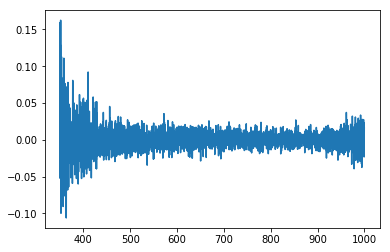

In [205]:
plt.plot(bbb[1].data['lambda'],bbb[1].data['mockgal'])

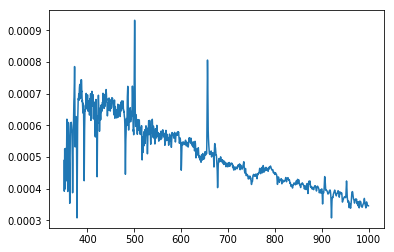

In [208]:
plt.plot(wavearr,galflux)
#plt.plot(wavearr,mockgal)